In [1]:
import sys
import pandas as pd
import numpy as np
from rdkit import Chem
import warnings
sys.path.append("../")
from tcad.tools.nntools import mol_to_torch_data, add_label, train_test_split, get_atom_features_dims
import networkx as nx
from tcad.tools.datatools import to_log_p
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader
from tcad.deep.models import GCN_Graph
from tcad.deep.fit import train_GCN, evaluate_GCN
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("../data/androgen_data.csv")
data.head()

,assay_type,canonical_smiles,molecule_chembl_id,standard_units,standard_value,target_organism,type
0,B,CC1=CC(C)(C)Nc2ccc3c(c21)/C(=C/c1ccsc1)Oc1ccc(...,CHEMBL134277,nM,215.0,Homo sapiens,IC50
1,B,CC1(C)C(=O)N(c2ccc(C#N)c(C(F)(F)F)c2)C(=O)N1CC...,CHEMBL146794,nM,77.0,Homo sapiens,IC50
2,B,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)...,CHEMBL2112885,nM,90.0,Homo sapiens,IC50
3,B,CC1=CC(C)(C)Nc2ccc3c(c21)/C(=C/c1ccccc1N(C)C)O...,CHEMBL336353,nM,1500.0,Homo sapiens,IC50
4,B,CC1=CC(C)(C)Nc2ccc3c(c21)/C(=C/c1ccccc1)Oc1c(F...,CHEMBL413309,nM,900.0,Homo sapiens,IC50


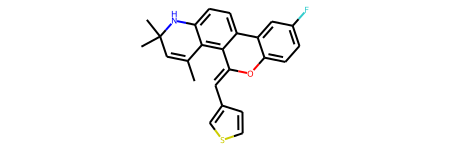

In [3]:
smiles = list(data['canonical_smiles'])
molecules = [Chem.MolFromSmiles(smile) for smile in smiles]
molecules[0]

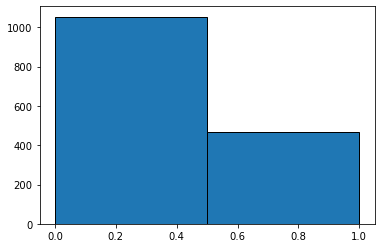

In [4]:
ACTIVITY_LVL = 5.5
labels = to_log_p(list(data['standard_value']))
labels = [1 if value < ACTIVITY_LVL else 0 for value in labels]

plt.hist(labels,2, edgecolor='black')
plt.show()


In [5]:
dataset = [mol_to_torch_data(mol) for mol in molecules]
dataset = [add_label(graph, label) for graph, label in zip(dataset, labels)]

Graph with 28 nodes and 32 edges


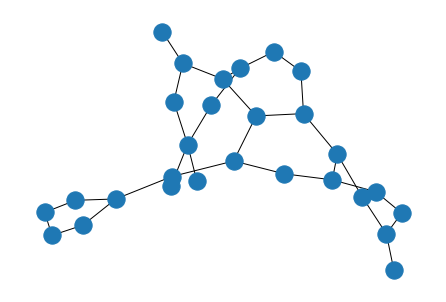

In [6]:
g = to_networkx(dataset[0], to_undirected=True)
nx.draw(g)
print(g)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 32

train_dataset, test_dataset = train_test_split(dataset, 0.3) 

train_data_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size)

In [24]:
model = GCN_Graph(512, 1, 1, 0.5,)
losses = []

for _ in tqdm(range(30)):
    loss = train_GCN(model, device, train_data_loader)
    losses.append(loss)


100%|██████████| 30/30 [01:08<00:00,  2.30s/it]


In [25]:
print(f"Accuracy: {evaluate_GCN(model, device, test_data_loader)}")

Accuracy: 77.582


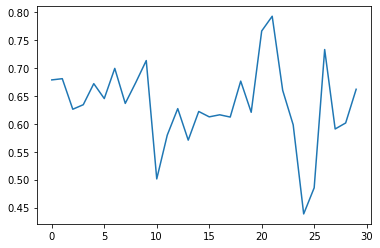

In [26]:
plt.plot(losses)
plt.show()

In [27]:
labels = []

for idx, batch in enumerate(train_data_loader):
    out = model.forward(batch,return_embeds=True)
    out = out.detach().numpy()
    labels+=[y.item() for y in batch.y]
    
    if idx == 0:
        outputs = out
    else:
        outputs = np.vstack((outputs, out))
 

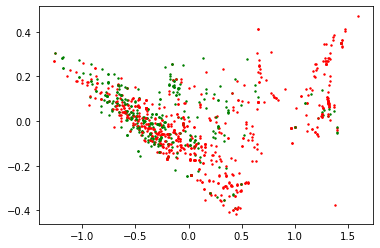

In [29]:
pca = PCA(2)
res = pca.fit_transform(outputs)

for data, label in zip(res, labels):

    if label==1:
        plt.scatter(x=data[0], y=data[1], color="green", s=2)
    else:
        plt.scatter(x=data[0], y=data[1], color="red", s=2)
plt.show()

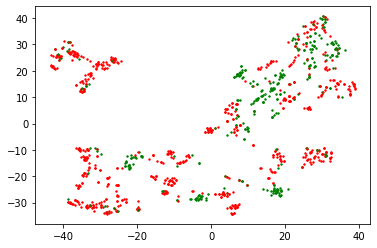

In [30]:
tsne = TSNE(2)
res = tsne.fit_transform(outputs)

for data, label in zip(res, labels):

    if label==1:
        plt.scatter(x=data[0], y=data[1], color="green", s=2)
    else:
        plt.scatter(x=data[0], y=data[1], color="red", s=2)
plt.show()